In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# reproducibility (tidak 100% deterministik di GPU tapi membantu)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("tensorflow:", tf.__version__)

numpy: 2.1.3
pandas: 2.3.0
tensorflow: 2.19.0


In [2]:
BASE_DIR = r"E:\Tugas Kuliah\Machine Learning\Tugas 4"
CSV_PATH = os.path.join(BASE_DIR, "btc_15m_data_2018_to_2025.csv")  # ganti jika file lain
MODEL_H5 = os.path.join(BASE_DIR, "lstm_btc_daily_model.h5")
MODEL_SAVED = os.path.join(BASE_DIR, "model_saved_tf")
SCALER_PATH = os.path.join(BASE_DIR, "scaler_minmax.joblib")

TIMESTEPS = 60
VAL_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
df = pd.read_csv(CSV_PATH)
display(df.head())
print("\nKolom dataset:", df.columns.tolist())

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00.000000,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999000,1.675545e+06,1572,63.227133,8.576108e+05,0
1,2018-01-01 00:15:00.000000,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999000,1.321757e+06,1461,47.686389,6.422812e+05,0
2,2018-01-01 00:30:00.000000,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999000,1.078825e+06,1000,43.710406,5.900347e+05,0
3,2018-01-01 00:45:00.000000,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999000,1.917783e+06,1195,73.897993,1.000614e+06,0
4,2018-01-01 01:00:00.000000,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999000,9.778198e+05,898,34.257652,4.618369e+05,0



Kolom dataset: ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']


In [4]:
time_col = None
for c in df.columns:
    if c.lower() in ("open time", "timestamp", "date", "datetime"):
        time_col = c; break
if time_col is None:
    raise ValueError(f"Tidak menemukan kolom waktu. Kolom: {df.columns.tolist()}")

df[time_col] = pd.to_datetime(df[time_col])
df = df.sort_values(by=time_col).set_index(time_col)
print("Range:", df.index.min(), "->", df.index.max())
display(df[['Close']].head())

Range: 2018-01-01 00:00:00 -> 2025-10-17 23:15:00


,Close
Open time,
2018-01-01 00:00:00,13556.15
2018-01-01 00:15:00,13521.12
2018-01-01 00:30:00,13470.41
2018-01-01 00:45:00,13529.01
2018-01-01 01:00:00,13445.63


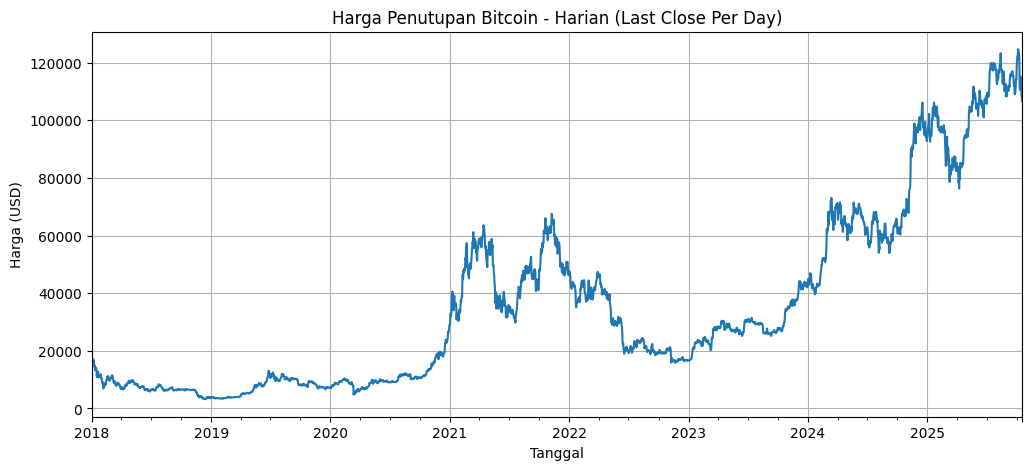

,Close
Open time,
2018-01-01,13380.00
2018-01-02,14675.11
2018-01-03,14919.51
2018-01-04,15059.54
2018-01-05,16960.39


Jumlah baris (harian): 2847
Missing values:
 Close    0
dtype: int64


,Close
count,2847.000000
mean,35712.615216
std,31147.296180
min,3211.720000
25%,9340.575000
50%,26747.780000
75%,54010.100000
max,124658.540000


In [5]:
if "Close" not in df.columns:
    raise ValueError("Kolom 'Close' tidak ditemukan.")
daily = df['Close'].resample('D').last().dropna()
plt.figure(figsize=(12,5))
daily.plot()
plt.title("Harga Penutupan Bitcoin - Harian (Last Close Per Day)")
plt.xlabel("Tanggal"); plt.ylabel("Harga (USD)"); plt.grid(True); plt.show()

data = daily.to_frame(name='Close').astype(float)
display(data.head())
print("Jumlah baris (harian):", len(data))
print("Missing values:\n", data.isna().sum())
display(data.describe())

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data[['Close']].values)  # (n,1)
print("Scaled shape:", scaled.shape)

Scaled shape: (2847, 1)


In [7]:
def make_dataset(values, window=60):
    X, y = [], []
    for i in range(window, len(values)):
        X.append(values[i-window:i, 0])
        y.append(values[i, 0])
    return np.array(X), np.array(y)

X, y = make_dataset(scaled, TIMESTEPS)
X = X.reshape((X.shape[0], X.shape[1], 1))   # (samples, timesteps, features=1)
print("Shape X:", X.shape, " Shape y:", y.shape)

Shape X: (2787, 60, 1)  Shape y: (2787,)


In [8]:
train_size = int(len(X) * (1 - VAL_RATIO))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
print("Train samples:", X_train.shape[0], " Val samples:", X_val.shape[0])

Train samples: 2229  Val samples: 558


In [9]:
from tensorflow.keras import layers, Model, Input

# Ambil timesteps dari dataset (X.shape = (N, 60, 1))
TIMESTEPS = int(X.shape[1])  # = 60

# Arsitektur yang kamu kirim (64 -> 32 -> Dense(1))
inputs = Input(shape=(TIMESTEPS, 1), name="input_layer")
x = layers.LSTM(64, return_sequences=True, name="lstm")(inputs)
x = layers.Dropout(0.2, name="dropout")(x)
x = layers.LSTM(32, return_sequences=False, name="lstm_1")(x)
x = layers.Dropout(0.2, name="dropout_1")(x)
outputs = layers.Dense(1, name="dense")(x)

model = Model(inputs, outputs, name="lstm_close_1d")
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "lstm_close_1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# EarlyStopping: hentikan saat val_loss tidak turun lagi (restore best weights)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Optional: kurangi learning rate saat stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [early_stop, reduce_lr]

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
callbacks = [early_stop, reduce_lr]

In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,    # penting untuk time series
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100
70/70 - 11s - 160ms/step - loss: 0.0037 - val_loss: 0.0126 - learning_rate: 1.0000e-03
Epoch 2/100
70/70 - 4s - 59ms/step - loss: 0.0042 - val_loss: 0.0081 - learning_rate: 1.0000e-03
Epoch 3/100
70/70 - 4s - 61ms/step - loss: 0.0030 - val_loss: 0.0036 - learning_rate: 1.0000e-03
Epoch 4/100
70/70 - 4s - 58ms/step - loss: 9.7042e-04 - val_loss: 9.8349e-04 - learning_rate: 1.0000e-03
Epoch 5/100
70/70 - 4s - 61ms/step - loss: 0.0012 - val_loss: 0.0010 - learning_rate: 1.0000e-03
Epoch 6/100
70/70 - 4s - 59ms/step - loss: 7.2708e-04 - val_loss: 0.0010 - learning_rate: 1.0000e-03
Epoch 7/100
70/70 - 4s - 59ms/step - loss: 9.9508e-04 - val_loss: 0.0011 - learning_rate: 1.0000e-03
Epoch 8/100
70/70 - 4s - 60ms/step - loss: 8.2173e-04 - val_loss: 8.9019e-04 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
70/70 - 5s - 68ms/step - loss: 7.0370e-04 - val_loss: 0.0011 - learning_rate: 1.0000e-03
Epoch 10/100
70/70 -

Best epoch (val_loss minimal) = 14


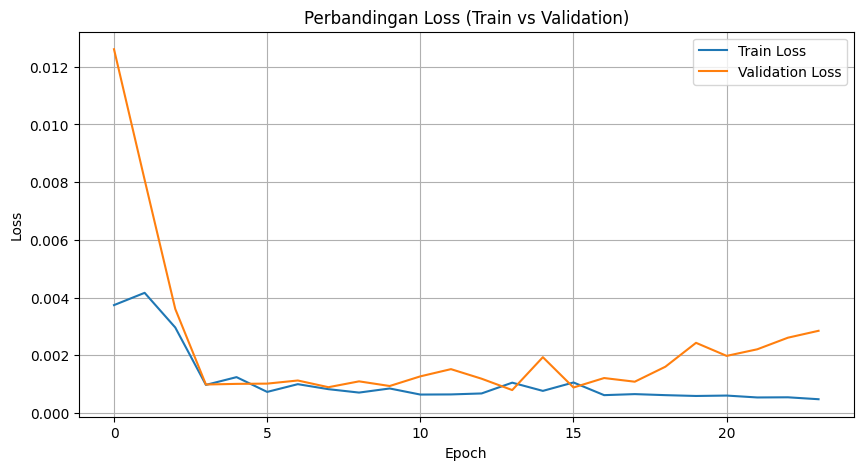

In [13]:
best_epoch = int(np.argmin(history.history['val_loss']) + 1)
print(f"Best epoch (val_loss minimal) = {best_epoch}")

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perbandingan Loss (Train vs Validation)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

RMSE: 3415.22 | MAE: 2627.72


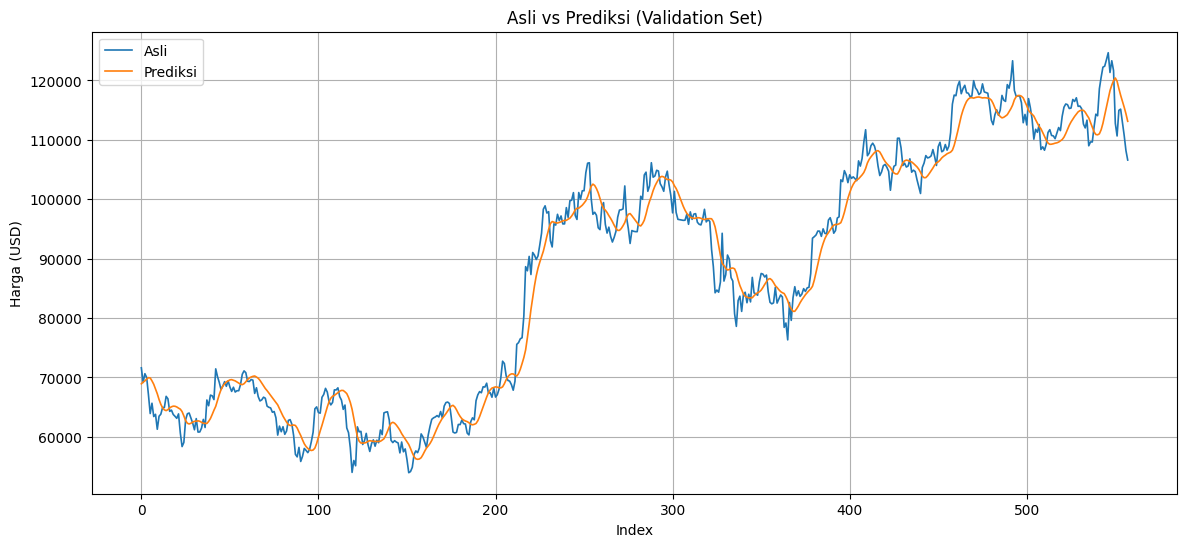

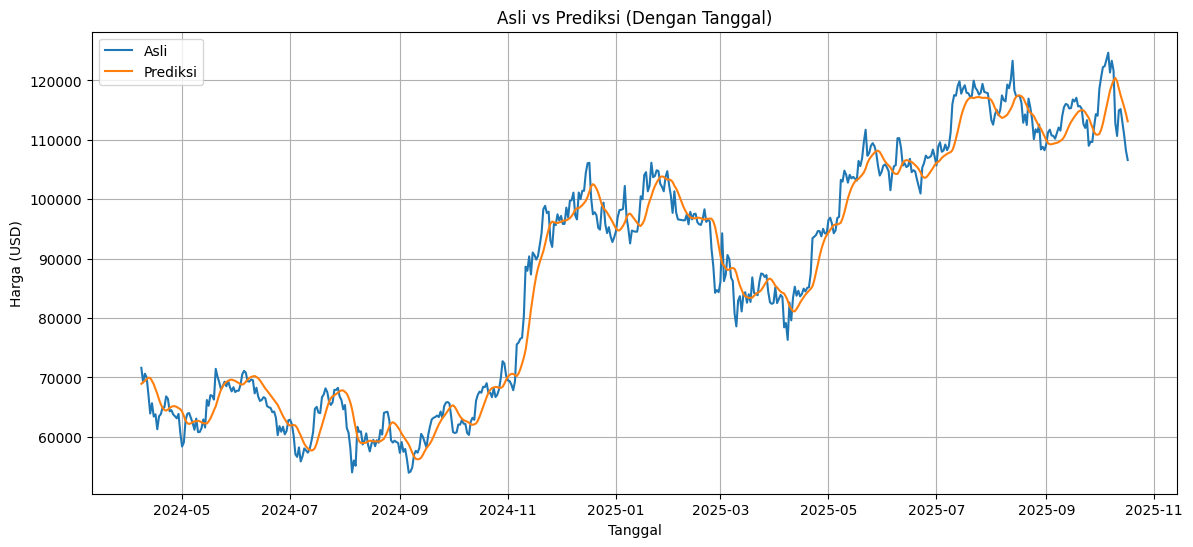

In [15]:
y_pred_scaled = model.predict(X_val, verbose=0)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred_scaled)

# Calculate RMSE manually (square root of MSE)
mse = mean_squared_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f}")

plt.figure(figsize=(14,6))
plt.plot(y_val_inv, label='Asli', linewidth=1.2)
plt.plot(y_pred_inv, label='Prediksi', linewidth=1.2)
plt.title('Asli vs Prediksi (Validation Set)')
plt.xlabel('Index'); plt.ylabel('Harga (USD)'); plt.legend(); plt.grid(True); plt.show()

# plot dengan tanggal (opsional)
dates = data.index[TIMESTEPS + train_size : TIMESTEPS + train_size + len(y_val_inv)]
plt.figure(figsize=(14,6))
plt.plot(dates, y_val_inv.flatten(), label='Asli')
plt.plot(dates, y_pred_inv.flatten(), label='Prediksi')
plt.title('Asli vs Prediksi (Dengan Tanggal)')
plt.xlabel('Tanggal'); plt.ylabel('Harga (USD)'); plt.legend(); plt.grid(True); plt.show()

In [16]:
# Simpan scaler
joblib.dump(scaler, SCALER_PATH)

# Bersihkan SavedModel lama
if os.path.isdir(MODEL_SAVED):
    shutil.rmtree(MODEL_SAVED)

# Simpan full H5 (bukan weights-only) dan SavedModel
model.save(MODEL_H5, include_optimizer=False)
model.save(MODEL_SAVED, save_format="tf")

print("Saved H5:", MODEL_H5)
print("Saved SavedModel:", MODEL_SAVED)
print("Saved Scaler:", SCALER_PATH)

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf